## Setup

To access material for this workbook please execute the two notebook cells immediately below (e.g. use the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>). The first cell can be skipped if you are running this notebook locally and have already installed all the necessary packages. The second cell should print out "Your notebook is ready to go!"

In [1]:
if 'pyodide_kernel' in str(get_ipython()):  # specify packages to install under JupyterLite
    %pip install -q -r jlite-requirements.txt
elif 'google.colab' in str(get_ipython()):  # specify package location for loading in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    %run /content/drive/MyDrive/GARG_workshop/Notebooks/add_module_path.py
else:  # install packages on your local machine (-q = "quiet": don't print out installation steps)
    !python -m pip install -q -r https://github.com/ebp-nor/GARG/raw/main/jlite/requirements.txt

In [1]:
# Load questions etc for this workbook
from IPython.display import SVG
import tskit
import ARG_workshop
workbook = ARG_workshop.Workbook1C()
display(workbook.setup)

✅ Your notebook is ready to go!


Found existing installation: tskit_arg_visualizer 0.0.1
Uninstalling tskit_arg_visualizer-0.0.1:
  Successfully uninstalled tskit_arg_visualizer-0.0.1
  Cloning https://github.com/kitchensjn/tskit_arg_visualizer to /private/var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/pip-req-build-b0c288qi
  Running command git clone --filter=blob:none --quiet https://github.com/kitchensjn/tskit_arg_visualizer /private/var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/pip-req-build-b0c288qi
  Resolved https://github.com/kitchensjn/tskit_arg_visualizer to commit 98e86972aed31fc501b3bd0783f1f72aef50e096
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tskit_arg_visualizer: filename=tskit_arg_visualizer-0.0.1-py3-none-any.whl size=23368 sha256=f6e28a005c8bb717180e377904770d7182278157853d22457d9e02b6e592617c
  Stored in directory: /private/var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/pip-ephem-whe

### Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

# Workbook 1-C: Pedigrees, graphs and recombination

Previously we explored genetic genealogies in the absence of recombination, when the relationships between a set of sample genomes can be depicted as a tree. In this case standard coalescent theory applies.

The theory and practice revolving around genetic genealogies with recombination is less well characterised. It is the main focus of this specific practical, and the workshop in general.

## The pedigree

In a species in which each diploid individual has two parents, the links from one individual to each of its (diploid) parents form a network known as a **pedigree**. Although the pedigree describes all possible routes of inheritance, in most cases involving real data, it is unknown. However, we wrote our `FwdWrightFisherSimulator` to keep track of the pedigree (in the `parents` column of the _individual_ table) as well as the routes of genetic transmission (in the _edge_ table).

In [3]:
# Show the individuals table from a simulation
ts = ARG_workshop.FwdWrightFisherSimulator(population_size=3).run(gens=2, filter_nodes=False)
ind = ts.individual(6)
print(f"The biological parents of individual {ind.id} are individuals {ind.parents[0]} and {ind.parents[1]}")
print(f"A parent value of {tskit.NULL} means the parent is unknown or undefined")
display(ts.tables.individuals)

The biological parents of individual 6 are individuals 5 and 3
A parent value of -1 means the parent is unknown or undefined


id,flags,location,parents,metadata
0,0,,"-1, -1",
1,0,,"-1, -1",
2,0,,"-1, -1",
3,0,,"0, 1",
4,0,,"0, 1",
5,0,,"0, 1",
6,0,,"5, 3",
7,0,,"4, 3",
8,0,,"4, 3",


### Genetic transmission is embedded in the pedigree

We can plot the pedigree stored in a tree sequence using the `draw_pedigree` workbook function (see also [pedigrees in the msprime docs](https://tskit.dev/msprime/docs/stable/pedigrees.html)). Below, each individual is a hexagon containing its node (genome) ids, with the pedigree shown as light grey lines. On the right, we have used `simplify()` to sample-resolve the tree sequence and retain the genetic ancestry of only 3 of the genomes at time 0 (ids 0, 4, and 10): the tskit edges are overlaid as black lines onto the pedigree. Note that we had to specify `keep_unary=True` when simplifying, *** of tree sequences often results in the loss of individuals, and therefore is likely to destroy the continuity of any pedigree.

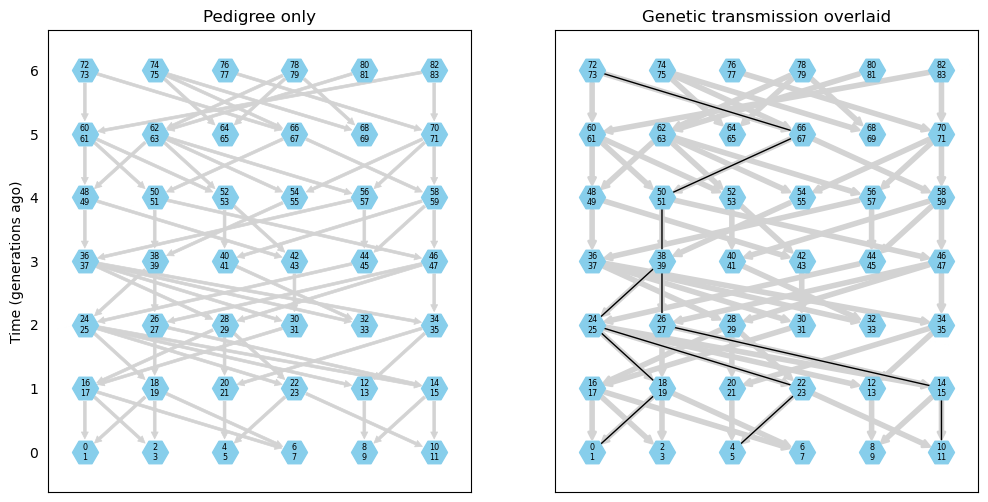

In [4]:
from matplotlib import pyplot as plt
# choose a random seed to give a nice viz without line crossing
sim = ARG_workshop.FwdWrightFisherSimulator(population_size=6, random_seed=21916)
base_ts = sim.run(gens=6, simplify=False)

# Sample-resolve to only 3 samples in the current generation (i.e. simplify, but keep all the nodes etc.)
S = [0,4,10]  # The sample IDs to use
ts = base_ts.simplify(samples=S, filter_nodes=False, keep_unary=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_params = {
    "node_color": "skyblue",
    "font_size": 5.8,
    "node_size":350,
    "node_shape": "H",
    "edge_color": "lightgrey",
    "arrowstyle": "simple",
}
ARG_workshop.draw_pedigree(base_ts, axes[0], "Pedigree only", show_axis=True, width=0.5, **plot_params)
ARG_workshop.draw_pedigree(ts, axes[1], "Genetic transmission overlaid", width=2, ts_edge="black", **plot_params)

## The effect of recombination

In the plot above there is no recombination, so each genome can only have one parent genome. In contrast, recombination leads to *biparental inheritance*, where some regions of the DNA sequence come from the mother and some from the father. For simplicity, we'll just deal with a single chromosome of length $L$ undergoing crossover recombination. Genetic inheritance is then described by *intervals* that span different regions from $0...L$. A _tskit_ **edge** consists of a _left_ and _right_ position defining the interval, together with a _parent_ and _child_ node.

Note: Modelling multiple chromosomes can be done, but is an advanced topic, see the [documentation]()

### A modified simulator
We can derive a new class from the `ARG_workshop.FwdWrightFisherSimulator` and add recombination by overriding the `add_edges` function. As is common in such simulators, we'll set a per-base-pair-per-generation "recombination rate", $\rho$  (in an average human chromosome of length $1\times10^8$ bp in length, $\rho$ tends to be between $1\times10^{-8}$ and $2\times10^{-8}$, giving one or two recombinations per chromosome). To record biparental inheritance, we create edges from the maternal or paternal genome of each parent to the child genome, using the `left` and `right` value to specify which region of the genome is being passed on.

To pick a location where recombination occurs, we choose a point at random along the chromosome. This means everywhere along the genome is 

In [5]:
import numpy as np
class FwdWrightFisherRecombSim(ARG_workshop.FwdWrightFisherSimulator):
    def add_edges(self, randomly_ordered_parent_nodes, child_node):
        L = self.tables.sequence_length
        num_breakpoints = self.rec_rng.poisson(L * self.recombination_rate, size=1)
        breakpoint_positions = np.unique([0, *self.rec_rng.integers(L, size=num_breakpoints), L])
        choose_genome = 0
        for left, right in zip(breakpoint_positions[:-1], breakpoint_positions[1:]):
            self.tables.edges.add_row(
                left=left,
                right=right,
                parent=randomly_ordered_parent_nodes[choose_genome],
                child=child_node,
            )
            choose_genome = 1 if choose_genome == 0 else 0

    def __init__(self, Ne, seq_len=1000, recombination_rate=1e-8, random_seed=21916):
        self.recombination_rate = recombination_rate
        # make a different random number generator to use to pick recombination breakpoints
        self.rec_rng = np.random.default_rng(seed=random_seed)
        super().__init__(Ne, seq_len, random_seed)  # calls the __init__ function of the underlying class


Here are some examples of the simulation results, showing both the *pedigree* and the darker lines of genetic transmission (the _tskit_ edges). The edge table from the low recombination example is shown underneath the plots.

Importantly, these tree sequences have been **sample-resolved**: that is, the edges have been trimmed down at the end of the simulation to show only the ancestry of three specific samples. Sample-resolution is inherently a retrospective process. it involves traversing backwards through the ancestry from the samples, removing non-ancestral sections of DNA, to leave only edge intervals that trace the history of "ancestral genetic material". This can't be done forwards in time, because we can't know in advance which spans of genome which will end up making it to the current day.

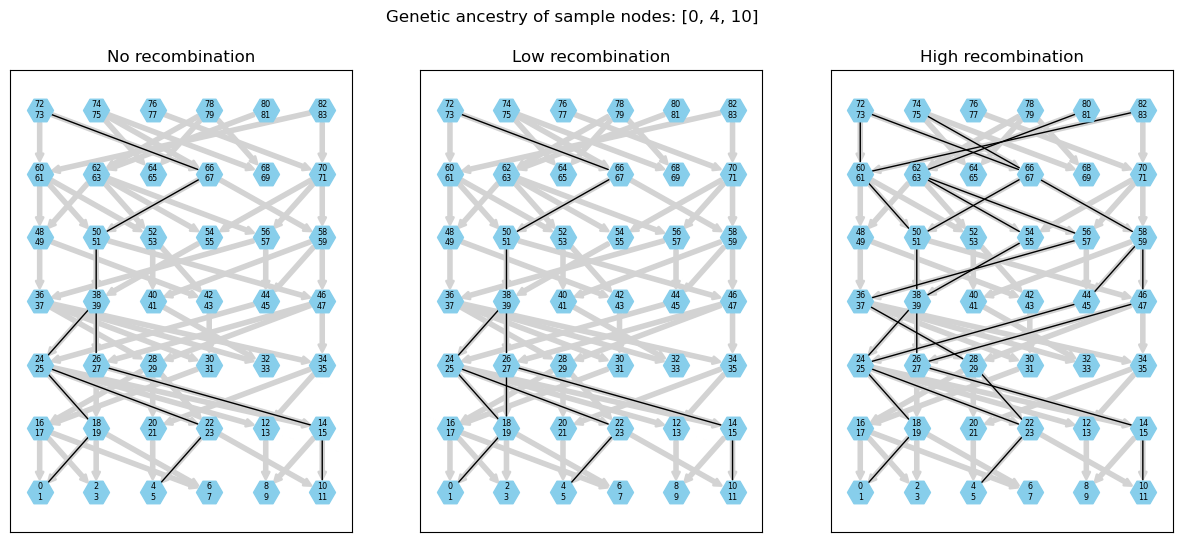

Edges from sample-resolved low-recombination simulation


id,left,right,parent,child,metadata
0,0,1000,15,10,
1,0,79,18,0,
2,79,1000,19,0,
3,0,1000,23,4,
4,0,79,25,18,
5,0,1000,25,23,
6,0,1000,27,15,
7,79,1000,27,19,
8,0,1000,38,25,
9,0,1000,38,27,


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(f"Genetic ancestry of sample nodes: {S}")
sim_params = {"gens": 6, "simplify": True, "samples": S, "filter_nodes": False, "keep_unary": True}
ts_no_recomb = FwdWrightFisherRecombSim(Ne=6, recombination_rate=0).run(**sim_params)
ts_low_recomb = FwdWrightFisherRecombSim(Ne=6, recombination_rate=1e-4).run(**sim_params)
ts_high_recomb = FwdWrightFisherRecombSim(Ne=6, recombination_rate=1e-3).run(**sim_params)
for name, ts, ax in zip(("No", "Low", "High"), (ts_no_recomb, ts_low_recomb, ts_high_recomb), axes):
    ARG_workshop.draw_pedigree(ts, ax, f"{name} recombination", width=2, ts_edge="black", **plot_params)
plt.show()
print("Edges from sample-resolved low-recombination simulation")
ts_low_recomb.tables.edges

The edge table shows a few edges that either start or end at position 79. This suggests that in the low-recombination simulation, only a single recombination event is present in the ancestry.

## Ancestral Recombination Graphs

The plots show that as the recombination rate increases, the ancestry of the samples gets more and more tangled. More specifically, the black lines form a network or **graph** rather than a tree. This inheritance structure is sometimes loosely referred to as an Ancestral Recombination Graph, or ARG. It has two main features:

* Assuming we can pick an equivalent position in each of the sample genomes, we can extract a *local tree* at that position (because particulate inheritance means that a single position can only have been inherited from one of the parental genomes)
* In the same way that we simplified trees by removing nodes, we can simplify ARGs (but the process is more intricate)

To illustrate both these points, it's helpful to visualise the ARG.

### Direct visualizations

There are 2 ways to directly visualise the relationships in an ARG:

* A traditional graph view. Below we use an [interactive visualiser developed for tree sequences](https://github.com/kitchensjn/tskit_arg_visualizer).
* A plot of the *local trees* implied by the tree sequence. This is the standard *tskit* view, with shading indicating the region covered by each tree.

<div class="alert alert-block alert-info"><b>Note:</b> Although tree-by-tree plots are the default visualization output by the <code>draw_svg()</code> method, it's important to realise that each tree is not stored separately in <em>tskit</em>, but constructed from the previous tree by adding and removing a small number of edges. Bear in mind that the same edge is therefore plotted multiple times, once in each local tree.
</div>

In [7]:
import tskit_arg_visualizer

def ARG_viz(ts, height=300, plot_edge_spans=True, edge_type="line", **kwargs):
    # Viz 1: graph
    d3arg = tskit_arg_visualizer.D3ARG.from_ts(ts, ignore_unattached_nodes=True)
    d3arg.draw(width=600, height=height, edge_type=edge_type)
    
    # Vis 2: local trees
    display(SVG(ts.draw_svg(y_axis=True, size=(1500, height))))

    # Viz 3: edge spans
    if plot_edge_spans:
        px = 1/plt.rcParams['figure.dpi'] 
        fig, ax = plt.subplots(1, 1, figsize=(1800*px, height*px))
        ARG_workshop.edge_plot(ts, ax)
        plt.show()

tts = ts_low_recomb
ARG_viz(tts)

ValueError: Node '8' not in the graph.

<dl class="exercise"><dt>Exercise 1</dt>
<dd>Have a play with the interactive visualiser (you can drag the nodes), and in particular, mouse over the bars at the bottom. Make sure you understand how the tree-by-tree view underneath corresponds to the interactive graph view. Then try the following 2 modifications, and rerun the code:
    <ol>
    <li>Use the <code>high_recomb_ts</code> instead of the <code>low_recomb_ts</code></li>
    <li>Plot a *fully simplified* version of the  <code>high_recomb_ts</code>, by applying <code>.simplify(filter_nodes=False)</code> before calling ARG_viz.</li>
    </ol>
Finally, in the cell below print the total number of trees along the genome in the high recombination example, using <code>ts.num_trees</code>:</dd>
</dl>

In [208]:
# Exercise 1: print out the number of trees in the simplified high recombination tree sequence

In [209]:
# Quiz - give an MRCA in the last tree. what is the number of trees

### Simplifying ARGs

When we simplified a tree sequence containing just a single tree, the possibilities were relatively simple. We could either *sample-resolve* (which removed edges), or *fully simplify* (which replaced edges such that pass-through nodes were bypassed). Simplifying an ARG is much more complex:
1. Edges may not be compeletely removed 

In the exercise above you saw the effect of *full simplification* on an ARG, but this is the most extreme of (at least) 5 levels of simplification that can be performed:

* **Level 1** Sample-resolve only: i.e. do not remove nodes from the graph but just remove edges or change edge spans to trace only the ancestry of the chosen sample nodes (this is what happens when simplifying with`keep_unary=True`)
* **Level 2** As above bus also remove pass-though ARG nodes (the result is sometimes known as a "full ARG")
* **Level 3** As above bus also remove "diamonds" and "super diamonds"
* **Level 4** As above bus also remove any node not associated with a local coalescence.
* **Level 5** Fully simplify: as above and remove all non-coalescent segments. This is the default level of `simplify` (when `keep_unary=False`) and was the result of the last part of the exercise above.

To investigate what's going on, we'll focus on the first section of the genome, from position 935-1000. We can do this by using the [delete_intervals](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.delete_intervals) function.

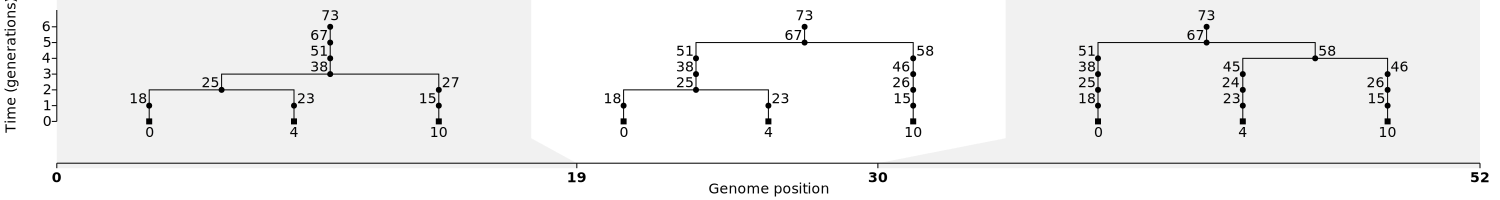

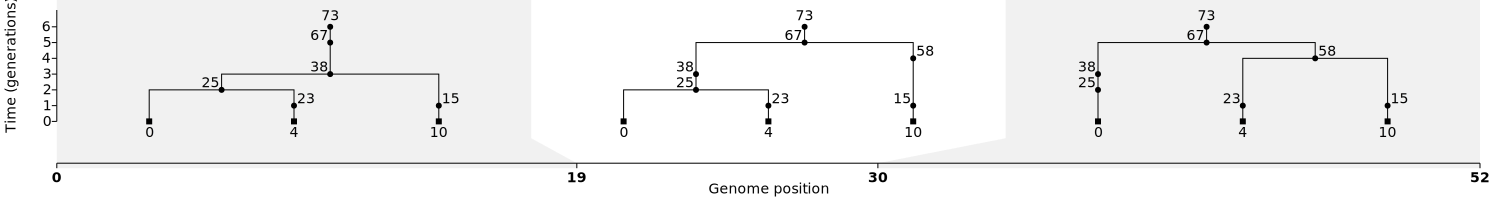

In [388]:
from IPython.display import HTML
ts_level1 = ts_high_recomb.keep_intervals([[0, 52]], simplify=False).trim()  # Fully simplifies by default, which we don't want yet
display(HTML("<h1>Sample-resolve only</h1>"))
ARG_viz(ts_level1, keep_unary=True, height=200, plot_edge_spans=False)

# NB: Tskit doesn't currently have an easy way to simplify to levels 2, 3, and 4, so we've provided a separate
# `ARG_workshop.partial_simplify()` function, which defaults to level 2. We'll also keep the root node 73
ts_level2 = ARG_workshop.partial_simplify(ts_level1, keep_input_roots=True, filter_nodes=False)
display(HTML("<h1>Remove pass-through</h1>"))
ARG_viz(ts_level2, keep_unary=True, height=200, plot_edge_spans=False)


Removing the pass-through ARG nodes keeps the same topology as in the purely sample-resolved ancestry, and it therefore a more efficient way of recording the genetic genealogy (although individuals associated with the removed nodes are lost, and therefore the pedigree cannot be recovered).

You'll also notice that the local trees still contain "locally unary" nodes. These are not topologically redundant: they convey useful information.

<dl class="exercise"><dt>Exercise 2</dt>
<dd>Answer the questions below
</dd>
</dl>

In [ ]:
# Node 16 is a coalescent node in the last tree
# Node 17 is 
# How do you transform the first tree into the 

### SPR moves

Locally unary nodes contain important information about the passage of history. One piece of that information is how to transform one local tree to an adjacent one. For instance, we can make the second tree from the first tree by taking the branch above node 17 changing its parent from node 40 to node 58. Likewise we can make the third tree from the second by taking the branch above 4 and changing its parent from 17 to 16. This is known as a "Subtree Prune and Regraft" (SPR) operation. As long as each recombination event in the ancestry happens at a new location, local trees will differ from each other by a single SPR, and  locally unary nodes provide information about where in the genetic genealogy this takes place.

The transition from one local tree to another along the genome is a key process in the ARG literature. For example, a number of key algorithms approximate ARGs by a process known as the sequential Markov coalescent (SMC or SMC'), in which the next local tree along the genome can be constructed only by consideration of the current local tree (in other words, that the left-to-right generation of local trees can be treated as Markovian). We will return to this in later workbooks.

### Removing singly-connected components

By removing locally unary nodes, the two further levels of simplification make it difficult to reconstruct the exact SPR moves

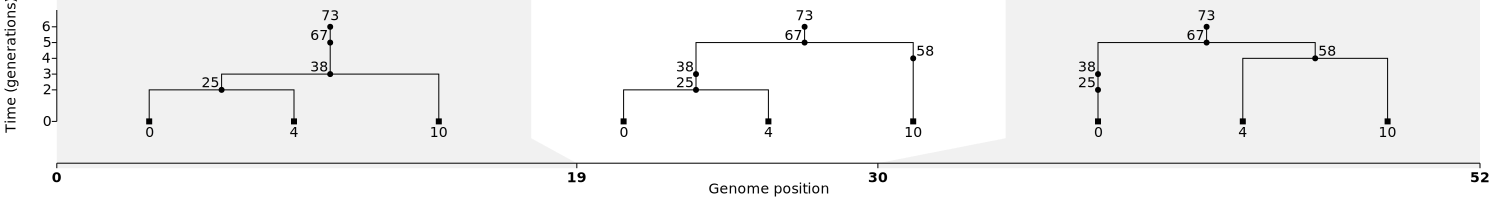

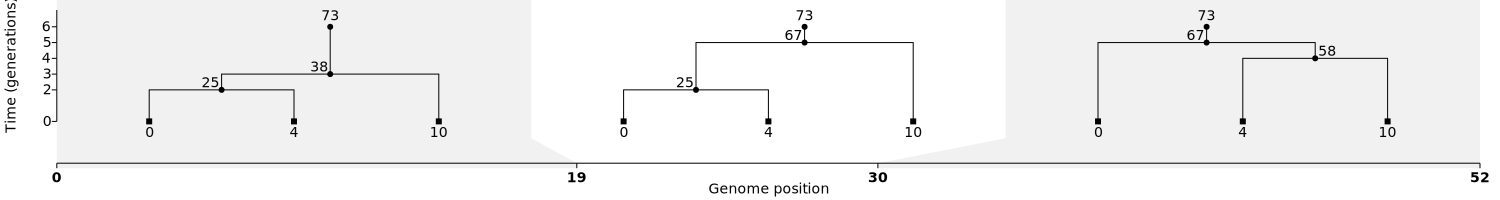

In [390]:
# NB: Tskit doesn't currently have an easy way to simplify to levels 2 and 3, so we've provided a separate
# `ARG_workshop.partial_simplify()` function, which defaults to level 2. We'll also keep the root nodes 83 and 76
ts_level3 = ARG_workshop.partial_simplify(ts_level1, remove_all_locally_unary=True, keep_input_roots=True, filter_nodes=False)
display(HTML("<h1>Remove pass-through</h1>"))
ARG_viz(ts_level3, keep_unary=True, height=200, plot_edge_spans=False)

ts_level4 = ts_level1.simplify(keep_input_roots=True, filter_nodes=False)
display(HTML("<h1>Fully simplified</h1>"))
ARG_viz(ts_level4, keep_unary=True, height=200, plot_edge_spans=False)


### Simplifying non-coalescent nodes

Coalescent nodes are important because we can infer their existence by looking for shared characteristics (e.g. shared mutations) between different samples. In contrast, nodes which are not coalescent anywhere are to some extent "invisible" (their existence can be inferred from DNA variation, but details of the order and timing of the nodes may be unknowable). Nevertheless, these nodes 


After removing pass-through nodes, two types of non-coalescent nodes can remain in an ARG:

1. Recombination nodes: Nodes with more than one parent, that represent a recombination event in which material from multiple parents has come together.
2. Common ancestor nodes: Nodes with two (or more) children, but where ancestral material from one child might be e.g. at one end of the chromosome, but material from the second child is at the other end.



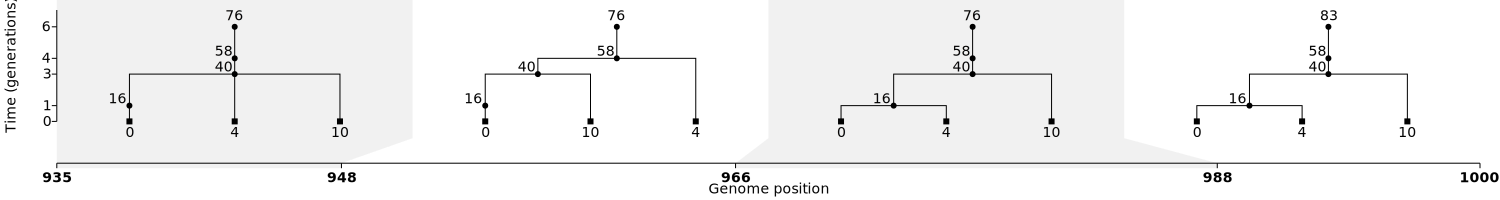

In [11]:
# Now remove all non-coalescent nodes
ts = ARG_workshop.partial_simplify(ts_end, keep_input_roots=True, remove_all_locally_unary=True, filter_nodes=False)
ARG_viz(ts, keep_unary=True, height=200, plot_edge_spans=False)

The only difference here is that simpification has removed node 17. This node was not coalescent anywhere in the tree sequence: it corresponded to a recombination. However, it's position is essentially unknowable. What we have done is to move the recombination node down onto the nearest coalescent node.

## Backward-time ARG simulation

In the same way that we were able to simulate coalescent trees in reverse time, we can also simulate ARGs in reverse time. The model for simulating these is known as the coalescent with recombination (CwR), and an efficient algorithm was introduced by Hudson (1982), which forms the basis of the _msprime_ simulator. 

### Each node can be treated as an *event*

For this, we assume that there are two sorts of genealogical events: common make the same assumption as in basic coalescent simulations: that each event happens at a separate time. One subtle distinction here is that nodes represent *events* *** Nodes in this world mean event ***

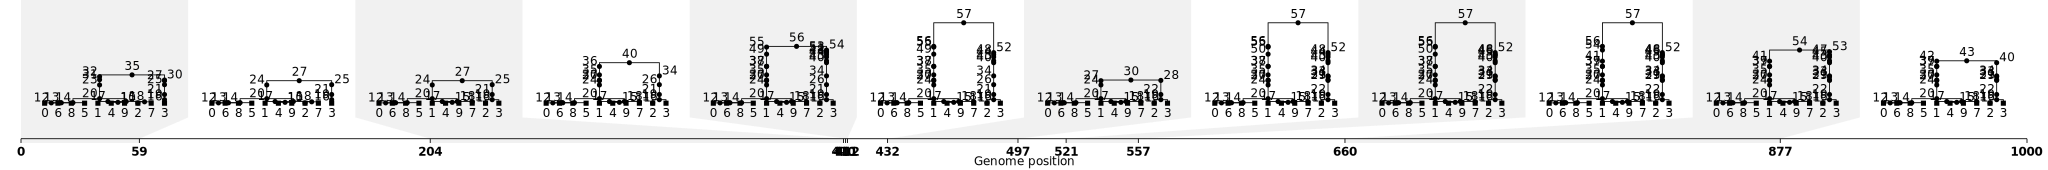

In [12]:
from IPython.display import SVG 
import msprime
import tskit_arg_visualizer
ts = msprime.sim_ancestry(5, population_size=100, sequence_length=1000, record_full_arg=True, recombination_rate=0.000018, random_seed=1)
#ARG_viz(ts, height=800)
ts.draw_svg()

In [8]:
d3arg = tskit_arg_visualizer.D3ARG.from_ts(ts)
d3arg.draw(width=600, height=500)
#ARG_viz(ts, edge_type="ortho", filter_nodes=False)

In [13]:
d3arg = tskit_arg_visualizer.D3ARG.from_ts(ARG_workshop.partial_simplify(ts))
d3arg.draw(width=600, height=500)
#ARG_viz(ts, edge_type="ortho", filter_nodes=False)

In [ ]:
# many breakpoints are not in "ancestral material"...

In [ ]:
Note: each local tree is a valid coalescent tree (in isolation). Example: calculate the average tMRCA... However, the corrleations betwen the trees make it tricky to do other stuff

## Each tree transition is an SPR


(Assuming that each breakpoint is unique) Use the interactive plots above to illustrate why this is so. A breakpoint corresponds to a switch in historical path.

Important implication: you can approximate using the SMC (throws away "long range correlations")



## msprime and record_full_arg

# Now introduce the (Griffiths) ARG / Hudson's CwR in which each node is an event....

A simpler model, in which each internal node represents a single event, which can either be a common ancestor event or a recombination event.

This assumes we have 

This model can be used for sampling, but there are a huge number of 

In [18]:
import msprime
ts = msprime.sim_ancestry(10)
tables = ts.dump_tables()
i_col = tables.nodes.individual
i_col[:] = tskit.NULL
tables.nodes.individual = i_col
print(tables.nodes.individual)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [24]:
np.unique(np.array([tables.edges.parent, tables.edges.child]).T, axis=0)[:,0]

array([20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28,
       28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36,
       37, 37, 38, 38], dtype=int32)

In [25]:
    keep_nodes = set()
    unique_edges = np.unique(np.array([tables.edges.parent, tables.edges.child]).T, axis=0)
    for i in (0, 1):
        uniq, count = np.unique(unique_edges[:, i], return_counts=True)
        keep_nodes.update(uniq[count > 1])


In [49]:
As we'll see tomorrow, different ARG inference software infers different sorts of "ARGs"

In [ ]:
Hidden recombination events and "trapped material".

In [1]:
import msprime
import tskit_arg_visualizer
ts = msprime.simulate(10)

d3arg = tskit_arg_visualizer.D3ARG.from_ts(ts)
d3arg.draw(width=600, height=600, edge_type="line")

d3arg = tskit_arg_visualizer.D3ARG.from_ts(ts.simplify([0,1,2]))
d3arg.draw(width=600, height=600, edge_type="line")

ValueError: Node '8' not in the graph.